In [1]:
import hashlib
import os
import pickle
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile
import tensorflow as tf
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def uncompress_files(file):
    features = []
    labels = []
    with ZipFile(file) as zipf:
        filenames_pbar = tqdm(zipf.namelist(), unit='files')
        for filename in filenames_pbar:
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image = Image.open(image_file)
                    image.load()
                    feature = np.array(image, dtype=np.float32).flatten()
                label = os.path.split(filename)[1][0]
                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)
train_features, train_labels = uncompress_files('notMNIST_train.zip')
test_features, test_labels = uncompress_files('notMNIST_test.zip')    

train_features, train_labels = resample(train_features, train_labels, n_samples = 150000)
print('All the data is loaded')

100%|███████████████████████████████████████████████████████████████████████| 10001/10001 [00:01<00:00, 6465.19files/s]


All the data is loaded


In [3]:
def normalize_grayscale(image_data):
    a = 0.1
    b = 0.9
    grayscale_min = 0
    grayscale_max = 255
    return a + (((image_data - grayscale_min)*(b - a))/(grayscale_max - grayscale_min))

train_features = normalize_grayscale(train_features)
test_features = normalize_grayscale(test_features)
print('Features are normalized')

Features are normalized


In [4]:
encoder = LabelBinarizer()
encoder.fit(train_labels)
train_labels = encoder.transform(train_labels)
test_labels = encoder.transform(test_labels)

train_labels = train_labels.astype('float32')
test_labels = test_labels.astype('float32')
print('Labels are One-Hot Encoded')

Labels are One-Hot Encoded


In [5]:
train_features, valid_features, train_labels, valid_labels = train_test_split(train_features, train_labels, test_size = 0.05, random_state = 0)

In [6]:
# Saving the data for easy access
pickle_file = 'notMNIST.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file ...')
    try:
        with open('notMNIST.pickle', 'wb') as pfile:
            pickle.dump({
                'train_features': train_features,
                'train_labels': train_labels,
                'valid_features': valid_features,
                'valid_labels': valid_labels,
                'test_features': test_features,
                'test_labels': test_labels
                
            }, pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
print('Data cached in pickle file.')

Data cached in pickle file.


In [7]:
# Reloading the data
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    train_features = pickle_data['train_features']
    train_labels = pickle_data['train_labels']
    valid_features = pickle_data['valid_features']
    valid_labels = pickle_data['valid_labels']
    test_features = pickle_data['test_features']
    test_labels = pickle_data['test_labels']
    del pickle_data
print('Data successfully loaded')

Data successfully loaded


In [8]:
features_count = 784
labels_count = 10
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)
weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
biases = tf.Variable(tf.zeros(labels_count))

train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# Linear Function WX+b
logits = tf.add(tf.matmul(features, weights), biases)

predictions = tf.nn.softmax(logits)

# Cross Entropy
cross_entropy = -tf.reduce_sum(labels*tf.log(predictions), reduction_indices=1)

# Training loss
loss = tf.reduce_mean(cross_entropy)

init = tf.global_variables_initializer()

# Test Case
with tf.Session() as sess:
    sess.run(init)
    sess.run(loss, feed_dict=train_feed_dict)
    sess.run(loss, feed_dict=valid_feed_dict)    
    sess.run(loss, feed_dict=test_feed_dict)
    biases_data = sess.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zero'
print('Test Case Passed')

Test Case Passed


In [9]:
correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accurcy function created')

Accurcy function created





Epoch  1/1:   0%|                                                                        | 0/1114 [00:00<?, ?batches/s]


Epoch  1/1:   0%|                                                                | 1/1114 [00:00<07:46,  2.39batches/s]


Epoch  1/1:   4%|██▊                                                            | 50/1114 [00:00<05:12,  3.40batches/s]


Epoch  1/1:   6%|███▋                                                           | 65/1114 [00:00<03:44,  4.68batches/s]


Epoch  1/1:   9%|█████▌                                                        | 101/1114 [00:01<02:35,  6.53batches/s]


Epoch  1/1:  13%|████████▏                                                     | 148/1114 [00:01<01:44,  9.28batches/s]


Epoch  1/1:  15%|█████████▍                                                    | 170/1114 [00:01<01:16, 12.33batches/s]


Epoch  1/1:  18%|███████████▏                                                  | 201/1114 [00:02<00:55, 16.38batches/s]


Epoch  1/1:  22%|████

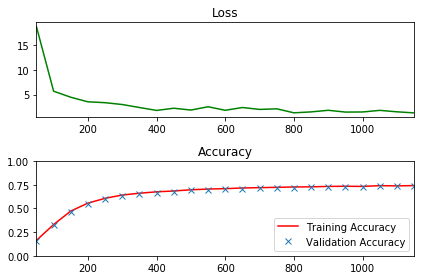

Validation accuracy at 0.7377333045005798


In [23]:
batch_size = 128
epochs = 1
learning_rate = 0.1

# Optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

validation_accuracy = 0.0

log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as sess:
    sess.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))
    
    for e in range(epochs):
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(e+1, epochs), unit='batches')
        for batch in batches_pbar:
            batch_start = batch*batch_size
            batch_features = train_features[batch_start:batch_start+batch_size]
            batch_labels = train_labels[batch_start:batch_start+batch_size]
            _,l = sess.run(
                [optimizer, loss],
                feed_dict = {features: batch_features, labels: batch_labels})
            if not batch % log_batch_step:
                train_acc = sess.run(accuracy, feed_dict=train_feed_dict)
                valid_acc = sess.run(accuracy, feed_dict=valid_feed_dict)
                
                # log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(train_acc)
                valid_acc_batch.append(valid_acc)
        validation_accuracy = sess.run(accuracy, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim(batches[0], batches[-1])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

In [24]:
test_accuracy = 0.0

with tf.Session() as session:
    
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)


assert test_accuracy >= 0.80, 'Test accuracy at {}, should be equal to or greater than 0.80'.format(test_accuracy)
print('Nice Job! Test Accuracy is {}'.format(test_accuracy))




Epoch  1/1:   0%|                                                                        | 0/1114 [00:00<?, ?batches/s]


Epoch  1/1:   3%|█▊                                                            | 33/1114 [00:00<00:03, 327.63batches/s]


Epoch  1/1:   8%|█████▏                                                        | 93/1114 [00:00<00:02, 378.04batches/s]


Epoch  1/1:  14%|████████▊                                                    | 161/1114 [00:00<00:02, 435.53batches/s]


Epoch  1/1:  20%|████████████▍                                                | 226/1114 [00:00<00:01, 482.59batches/s]


Epoch  1/1:  26%|████████████████                                             | 293/1114 [00:00<00:01, 525.89batches/s]


Epoch  1/1:  32%|███████████████████▋                                         | 359/1114 [00:00<00:01, 558.99batches/s]


Epoch  1/1:  38%|███████████████████████▏                                     | 423/1114 [00:00<00:01, 579.90batches/s]


Epoch  1/1:  43%|████

Nice Job! Test Accuracy is 0.8119000196456909
